In [ ]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay










In [ ]:
# initialize a new game
def new_game(n):
    matrix = np.zeros([n, n])
    return matrix

# add 2 or 4 in the matrix
def add_two(mat):
    empty_cells = []
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j] == 0:
                empty_cells.append((i, j))
    if len(empty_cells) == 0:
        return mat

    index_pair = empty_cells[random.randint(0, len(empty_cells) - 1)]

    prob = random.random()
    if prob >= 0.9:
        mat[index_pair[0]][index_pair[1]] = 4
    else:
        mat[index_pair[0]][index_pair[1]] = 2
    return mat

# to check state of the game
def game_state(mat):
    # if 2048 in mat:
    # return 'win'

    for i in range(len(mat) - 1):  # check the row on the right and below
        for j in range(len(mat[0]) - 1): 
            if mat[i][j] == mat[i + 1][j] or mat[i][j + 1] == mat[i][j]:
                return 'not over'

    for i in range(len(mat)):  # check for any zero entries
        for j in range(len(mat[0])):
            if mat[i][j] == 0:
                return 'not over'

    for k in range(len(mat) - 1):  #  check the left/right entries on the last row
        if mat[len(mat) - 1][k] == mat[len(mat) - 1][k + 1]:
            return 'not over'

    for j in range(len(mat) - 1):  # check up/down entries on last column
        if mat[j][len(mat) - 1] == mat[j + 1][len(mat) - 1]:
            return 'not over'

    return 'lose'

def reverse(mat):
    new = []
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0]) - j - 1])
    return new

def transpose(mat):
    return np.transpose(mat)

def cover_up(mat):
    new = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if mat[i][j] != 0:
                new[i][count] = mat[i][j]
                if j != count:
                    done = True
                count += 1
    return (new, done)

def merge(mat):
    done = False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat[i][j] == mat[i][j + 1] and mat[i][j] != 0:
                mat[i][j] *= 2
                score += mat[i][j]
                mat[i][j + 1] = 0
                done = True
    return (mat, done, score)

# up move
def up(game):
    game = transpose(game)
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = transpose(game)
    return (game, done, temp[2])

# down move
def down(game):
    game = reverse(transpose(game))
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = transpose(reverse(game))
    return (game, done, temp[2])

# left move
def left(game):
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    return (game, done, temp[2])

# right move
def right(game):
    game = reverse(game)
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = reverse(game)
    return (game, done, temp[2])

In [ ]:
# Controls
controls = {0: up, 1: left, 2: right, 3: down}


# convert the input game matrix into corresponding power of 2 matrix.
def change_values(X):
    power_mat = np.zeros(shape=(1, 4, 4, 16), dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if (X[i][j] == 0):
                power_mat[0][i][j][0] = 1.0
            else:
                # check for safety, as log(X[i][j], 2) can fail for non-powers of 2 if that was possible
                power = int(math.log(X[i][j], 2))
                if power < 16: # Ensure the index is within bounds (0-15)
                    power_mat[0][i][j][power] = 1.0
    return power_mat

# find the number of empty cells in the game matrix.
def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if (mat[i][j] == 0):
                count += 1
    return count

In [4]:
# --- Hyper Parameters  ---
start_learning_rate = 0.0005
gamma = 0.9
epsilon = 0.9
replay_memory = list()
replay_labels = list()
mem_capacity = 6000

# --- Network Architecture  ---
depth1 = 128
depth2 = 128
batch_size = 512
input_units = 16
hidden_units = 256
output_units = 4

In [ ]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random
import math
import pandas as pd
import os
from google.colab import drive
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# --- HYPERPARAMETERS ---
depth1 = 128
depth2 = 128
input_units = 16
hidden_units = 256
output_units = 4
batch_size = 512
mem_capacity = 6000
epsilon = 0.9
gamma = 0.9
start_learning_rate = 0.0005



# ---  Keras Model Definition  ---
def create_q_model(input_shape):
    input_tensor = Input(shape=input_shape)
    dataset = input_tensor

    # Layer 1
    conv1 = Conv2D(depth1, (1, 2), padding='valid', activation='relu')(dataset)
    conv2 = Conv2D(depth1, (2, 1), padding='valid', activation='relu')(dataset)

    # Layer 2
    conv11 = Conv2D(depth2, (1, 2), padding='valid', activation='relu')(conv1)
    conv12 = Conv2D(depth2, (2, 1), padding='valid', activation='relu')(conv1)
    conv21 = Conv2D(depth2, (1, 2), padding='valid', activation='relu')(conv2)
    conv22 = Conv2D(depth2, (2, 1), padding='valid', activation='relu')(conv2)

    # Flatten and Concatenate
    hidden_tensors = [
        Flatten()(conv1), Flatten()(conv2),
        Flatten()(conv11), Flatten()(conv12),
        Flatten()(conv21), Flatten()(conv22)
    ]
    hidden = Concatenate(axis=1)(hidden_tensors)

    # Fully Connected Layers
    hidden = Dense(hidden_units, activation='relu')(hidden)
    output = Dense(output_units, activation='linear')(hidden)

    return Model(inputs=input_tensor, outputs=output)

# Instantiate the model
input_shape = (4, 4, input_units)
q_model = create_q_model(input_shape)
target_q_model = create_q_model(input_shape)
target_q_model.set_weights(q_model.get_weights())

# --- Optimizer and Loss Setup ---
lr_schedule = ExponentialDecay(
    initial_learning_rate=start_learning_rate,
    decay_steps=1000,
    decay_rate=0.90,
    staircase=True
)

optimizer = RMSprop(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(states, labels):
    with tf.GradientTape() as tape:
        logits = q_model(states, training=True)
        loss = 0.5 * loss_fn(labels, logits)
    gradients = tape.gradient(loss, q_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, q_model.trainable_variables))
    return loss



#  Checkpoint Setup and Loading  
# did a checkpoint saving of training of model because it was getting timed out/connection lost in colab

# 1. Define Paths and Frequency
try:
    drive.mount('/content/drive')
except Exception:
    print("Drive already mounted.")

CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/2048_game/'
MODEL_CKPT_FILE = os.path.join(CHECKPOINT_DIR, 'q_model_checkpoint.keras')
DATA_CKPT_FILE = os.path.join(CHECKPOINT_DIR, 'training_data_checkpoint.csv')

SAVE_FREQUENCY = 5 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


# 2. Initialize or Load Variables
maximum = -1
episode = -1
total_iters = 1
back = 0
target_update_freq = 100
J = []
scores = []
M = 5000

if os.path.exists(MODEL_CKPT_FILE) and os.path.exists(DATA_CKPT_FILE):
    try:
        # Load Model Weights
        q_model.load_weights(MODEL_CKPT_FILE)
        target_q_model.set_weights(q_model.get_weights())

        # Load Data Lists
        data_df = pd.read_csv(DATA_CKPT_FILE)
        J = data_df['Loss'].tolist()
        scores = data_df['Score'].tolist()

        # Resume Training State Variables
        if not data_df.empty:
            last_entry = data_df.iloc[-1]
            last_episode = int(last_entry['Episode'])

            # Resume from the next episode
            start_episode = last_episode + 1
            M = max(0, M - start_episode)

            
            print(f"✅ RESUMING: Starting from Episode {start_episode}. Loaded {len(J)} loss steps.")

    except Exception as e:
        print(f"⚠️ Warning: Could not load checkpoint data. Starting fresh. Error: {e}")
        start_episode = 0
else:
    print("Starting fresh training run. No checkpoints found.")
    start_episode = 0



# Training Loop

for ep in range(start_episode, M + start_episode): 
    board = new_game(4)
   
    add_two(board)
    add_two(board)

    finish = 'not over'
    total_score = 0
    local_iters = 1
    total_iters = 1 

    while(finish=='not over'):
        prev_board = deepcopy(board)

        # Get Q-values
        state_tensor = change_values(prev_board)
        control_scores = q_model(state_tensor).numpy()
        control_buttons = np.flip(np.argsort(control_scores),axis=1)
        labels = deepcopy(control_scores[0])
        num = random.uniform(0,1)
        prev_max = np.max(prev_board)
        con = -1

        # --- Epsilon Greedy Logic  ---
        if(num < epsilon):
            
            legal_moves = list()
            for i in range(4):
                temp_board = deepcopy(prev_board)
                temp_board, _, _ = controls[i](temp_board)
                if(not np.array_equal(temp_board, prev_board)):
                    legal_moves.append(i)
            if(len(legal_moves) == 0):
                finish = 'lose'
                continue
            con = random.sample(legal_moves, 1)[0]
            temp_state = deepcopy(prev_board)
            temp_state, _, score = controls[con](temp_state)

            empty1 = findemptyCell(prev_board)
            empty2 = findemptyCell(temp_state)
            if(game_state(temp_state)=='not over'):
                temp_state = add_two(temp_state)
            board = deepcopy(temp_state)
            total_score += score
            finish = game_state(board)
            next_max = np.max(board)
            raw_reward = 0
            if (next_max > prev_max):
                 raw_reward = math.log(next_max, 2) * 0.1
            raw_reward += (empty2 - empty1)
            next_state_tensor = change_values(board)
            target_scores = target_q_model(next_state_tensor).numpy()
            max_qvalue = np.max(target_scores)
            labels[con] = raw_reward + gamma * max_qvalue
        else:
            
            for action_index in control_buttons[0]:
                prev_state = deepcopy(prev_board)
                temp_state, _, score = controls[action_index](prev_state)
                if(np.array_equal(prev_board, temp_state)):
                    labels[action_index] = 0
                    continue
                con = action_index
                empty1 = findemptyCell(prev_board)
                empty2 = findemptyCell(temp_state)
                if(game_state(temp_state)=='not over'):
                    temp_state = add_two(temp_state)
                board = deepcopy(temp_state)
                total_score += score
                finish = game_state(board)
                next_max = np.max(board)
                raw_reward = 0
                if (next_max > prev_max):
                     raw_reward = math.log(next_max, 2) * 0.1
                raw_reward += (empty2 - empty1)
                next_state_tensor = change_values(board)
                target_scores = target_q_model(next_state_tensor).numpy()
                max_qvalue = np.max(target_scores)
                labels[con] = raw_reward + gamma * max_qvalue
                break
            if con == -1 or np.array_equal(prev_board, board):
                finish = 'lose'

        
        if((ep > 10000) or (epsilon > 0.1 and total_iters % 2500 == 0)):
            epsilon = epsilon / 1.005

        # Store in memory
        prev_state_tensor = change_values(prev_board)
        replay_labels.append(labels)
        replay_memory.append(prev_state_tensor)

        # --- Back-propagation ---
        if(len(replay_memory) >= mem_capacity):
            
            back_loss = 0.0
            z = list(zip(replay_memory, replay_labels))
            random.shuffle(z)
            replay_memory, replay_labels = zip(*z)

            batch_num = 0
            for i in range(0, len(replay_memory), batch_size):
                if(i + batch_size > len(replay_memory)):
                    break
                batch_data = np.concatenate(replay_memory[i:i+batch_size], axis=0)
                batch_labels = np.array(replay_labels[i:i+batch_size], dtype=np.float32).reshape(batch_size, output_units)
                l = train_step(tf.constant(batch_data), tf.constant(batch_labels)).numpy()
                back_loss += l
                print("Mini-Batch - {} Back-Prop : {}, Loss : {}".format(batch_num, back, l))
                batch_num +=1

            back_loss /= batch_num
            J.append(back_loss)

            # --- CHECKPOINT 1: SAVE MODEL AND DATA PERIODICALLY ---
            if back % SAVE_FREQUENCY == 0:
                # Save Model Weights
                q_model.save(MODEL_CKPT_FILE)

                # Save Data History (Scores and Losses)
                scores_df = pd.DataFrame({'Score': scores})
                scores_file_path = os.path.join(CHECKPOINT_DIR, 'scores_checkpoint.csv')
                scores_df.to_csv(scores_file_path, index=False)

                loss_df = pd.DataFrame({'Loss': J})
                loss_file_path = os.path.join(CHECKPOINT_DIR, 'loss_checkpoint.csv')
                loss_df.to_csv(loss_file_path, index=False)

                print(f"--- CHECKPOINT: Model and Data saved at Back-Prop Step {back} ---")


            # Update Target Network
            if back % target_update_freq == 0:
                target_q_model.set_weights(q_model.get_weights())

            back += 1
            replay_memory = list()
            replay_labels = list()


        if(local_iters%400==0):
            print("Episode : {}, Score : {}, Iters : {}, Finish : {}".format(ep,total_score,local_iters,finish))

        local_iters += 1
        total_iters += 1

    scores.append(total_score)

    # Logging/Printing
    current_lr = optimizer.learning_rate.numpy()
    print("Episode {} finished with score {}, result : {} board : {}, epsilon : {}, learning rate : {} "
      .format(ep,total_score,finish,board,epsilon,current_lr))
    print()

    if((ep+1)%1000==0):
        print("Maximum Score : {} ,Episode : {}".format(maximum,episode))
        if J:
            print("Loss : {}".format(J[len(J)-1]))
        print()

    if(maximum < total_score):
        maximum = total_score
        episode = ep

print("Maximum Score : {} ,Episode : {}".format(maximum,episode))





Episode 0 finished with score 2552.0, result : lose board : [[4, 2, np.float64(4.0), 2], [np.float64(16.0), np.float64(8.0), np.float64(2.0), np.float64(4.0)], [np.float64(2.0), np.float64(128.0), np.float64(4.0), 2], [np.float64(4.0), np.float64(8.0), np.float64(256.0), np.float64(4.0)]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 1 finished with score 1000.0, result : lose board : [[  2.   4.   2.   4.]
 [  4.  32. 128.   2.]
 [  8.  16.   8.   4.]
 [  4.   2.  16.   2.]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 2 finished with score 1436.0, result : lose board : [[np.float64(4.0), np.float64(16.0), np.float64(4.0), np.float64(2.0)], [2, np.float64(64.0), np.float64(16.0), np.float64(32.0)], [np.float64(4.0), np.float64(32.0), np.float64(128.0), np.float64(2.0)], [np.float64(2.0), np.float64(8.0), np.float64(2.0), np.float64(8.0)]], epsilon  : 0.9, learning rate : 0.0005000000237487257 

Episode 3 finished with score 344.0, result : lose b

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
import random
import math
import time

from tkinter import *
from random import randint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Concatenate

In [37]:
# --- 1. NETWORK ARCHITECTURE AND MODEL LOADING ---

# Architecture constants 
depth1 = 128
depth2 = 128
input_depth = 16
hidden_units = 256
output_units = 4
input_shape = (4, 4, input_depth)

# Define the model structure

def create_q_model(input_shape):
    input_tensor = Input(shape=input_shape)
    dataset = input_tensor

    conv1 = Conv2D(depth1, (1, 2), padding='valid', activation='relu')(dataset)
    conv2 = Conv2D(depth1, (2, 1), padding='valid', activation='relu')(dataset)
    conv11 = Conv2D(depth2, (1, 2), padding='valid', activation='relu')(conv1)
    conv12 = Conv2D(depth2, (2, 1), padding='valid', activation='relu')(conv1)
    conv21 = Conv2D(depth2, (1, 2), padding='valid', activation='relu')(conv2)
    conv22 = Conv2D(depth2, (2, 1), padding='valid', activation='relu')(conv2)

    hidden_tensors = [
        Flatten()(conv1), Flatten()(conv2),
        Flatten()(conv11), Flatten()(conv12),
        Flatten()(conv21), Flatten()(conv22)
    ]
    hidden = Concatenate(axis=1)(hidden_tensors)
    hidden = Dense(hidden_units, activation='relu')(hidden)
    output = Dense(output_units, activation='linear')(hidden)

    return Model(inputs=input_tensor, outputs=output)

In [38]:
# --- LOAD TRAINED MODEL ---



MODEL_PATH = "q_model_checkpoint.keras"

try:
   
    q_model = tf.keras.models.load_model(MODEL_PATH)
    print(f"Successfully loaded trained model from {MODEL_PATH}")
except Exception as e:
    print(f"ERROR LOADING MODEL: {e}")
    print("Ensure the path is correct and the file exists.")


q_model.trainable = False

Successfully loaded trained model from q_model_checkpoint.keras


In [39]:
# --- 2. GAME LOGIC ---
def new_game(n):
    matrix = np.zeros([n, n], dtype=int)
    return matrix

def add_two(mat):
    empty_cells = []
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                empty_cells.append((i,j))
    if(len(empty_cells)==0):
        return mat
    index_pair = empty_cells[random.randint(0,len(empty_cells)-1)]

    num = np.random.random(1)
    if(num>0.9):
        mat[index_pair[0]][index_pair[1]]=4
    else:
        mat[index_pair[0]][index_pair[1]]=2
    return mat

def game_state(mat):
    for i in range(len(mat)-1):
        for j in range(len(mat[0])-1):
            if mat[i][j]==mat[i+1][j] or mat[i][j+1]==mat[i][j]:
                return 'not over'
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            if mat[i][j]==0:
                return 'not over'
    for k in range(len(mat)-1):
        if mat[len(mat)-1][k]==mat[len(mat)-1][k+1]:
            return 'not over'
    for j in range(len(mat)-1):
        if mat[j][len(mat)-1]==mat[j+1][len(mat)-1]:
            return 'not over'
    return 'lose'

def reverse(mat):
    new = []
    for i in range(len(mat)):
        new.append([])
        for j in range(len(mat[0])):
            new[i].append(mat[i][len(mat[0]) - j - 1])
    return new

def transpose(mat):
    return np.transpose(mat)

def cover_up(mat):
    
    mat_list = [list(row) for row in mat]
    new = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if mat_list[i][j] != 0:
                new[i][count] = mat_list[i][j]
                if j != count:
                    done = True
                count += 1
    return (new, done)

def merge(mat):
  
    mat_list = [list(row) for row in mat]
    done = False
    score = 0
    for i in range(4):
        for j in range(3):
            if mat_list[i][j] == mat_list[i][j + 1] and mat_list[i][j] != 0:
                mat_list[i][j] *= 2
                score += mat_list[i][j]
                mat_list[i][j + 1] = 0
                done = True
    return (mat_list, done, score)

def up(game):
    game = transpose(game)
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = transpose(game)
    return (game, done, temp[2])

def down(game):
    game = reverse(transpose(game))
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = transpose(reverse(game))
    return (game, done, temp[2])

def left(game):
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    return (game, done, temp[2])

def right(game):
    game = reverse(game)
    game, done = cover_up(game)
    temp = merge(game)
    game = temp[0]
    done = done or temp[1]
    game = cover_up(game)[0]
    game = reverse(game)
    return (game, done, temp[2])

def findemptyCell(mat):
    count = 0
    for i in range(len(mat)):
        for j in range(len(mat)):
            if(mat[i][j]==0):
                count+=1
    return count

def change_values(X):
    X_np = np.array(X)
    power_mat = np.zeros(shape=(1,4,4,16),dtype=np.float32)
    for i in range(4):
        for j in range(4):
            if(X_np[i][j]==0):
                power_mat[0][i][j][0] = 1.0
            else:
                power = int(math.log(X_np[i][j],2))
                if power < 16:
                    power_mat[0][i][j][power] = 1.0
    return power_mat

controls = {0:up,1:left,2:right,3:down}




In [40]:
# --- 3. GAME VISUALIZATION ---

SIZE = 500
GRID_LEN = 4
GRID_PADDING = 10


BACKGROUND_COLOR_GAME = "#808B96"      
BACKGROUND_COLOR_CELL_EMPTY = "#BFC9CA" 
FONT = ("Verdana", 40, "bold")

BACKGROUND_COLOR_DICT = {   
    2:"#AED6F1", 4:"#7FB3D5", 8:"#5499C7", 16:"#4A76A8", 
    32:"#00BCD4", 64:"#009688", 128:"#00796B", 256:"#4CAF50", 
    512:"#8BC34A", 1024:"#CDDC39", 2048:"#FFEB3B" 
}

CELL_COLOR_DICT = { 
    2:"#2C3E50", 4:"#2C3E50", 8:"#ECF0F1", 16:"#ECF0F1", 
    32:"#ECF0F1", 64:"#ECF0F1", 128:"#ECF0F1", 256:"#ECF0F1", 
    512:"#2C3E50", 1024:"#2C3E50", 2048:"#2C3E50" 
}


        

class GameGrid(Frame):
    def __init__(self):
        Frame.__init__(self)

        self.grid()
        self.master.title('2048')

        self.grid_cells = []
        self.init_grid()
        self.init_matrix()
        self.update_grid_cells()
        
        self.wait_visibility()
        self.after(10,self.make_move)
        
    def init_grid(self):
        background = Frame(self, bg=BACKGROUND_COLOR_GAME, width=SIZE, height=SIZE)
        background.grid()
        for i in range(GRID_LEN):
            grid_row = []
            for j in range(GRID_LEN):
                cell = Frame(background, bg=BACKGROUND_COLOR_CELL_EMPTY, width=SIZE/GRID_LEN, height=SIZE/GRID_LEN)
                cell.grid(row=i, column=j, padx=GRID_PADDING, pady=GRID_PADDING)
                t = Label(master=cell, text="", bg=BACKGROUND_COLOR_CELL_EMPTY, justify=CENTER, font=FONT, width=4, height=2)
                t.grid()
                grid_row.append(t)

            self.grid_cells.append(grid_row)

    def init_matrix(self):
        self.matrix = new_game(4)
        self.matrix=add_two(self.matrix)
        self.matrix=add_two(self.matrix)

    def update_grid_cells(self):
        for i in range(GRID_LEN):
            for j in range(GRID_LEN):
                new_number = self.matrix[i][j]
                if new_number == 0:
                    self.grid_cells[i][j].configure(text="", bg=BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(text=str(new_number), 
                                                    bg=BACKGROUND_COLOR_DICT.get(new_number, BACKGROUND_COLOR_DICT[2048]), 
                                                    fg=CELL_COLOR_DICT.get(new_number, CELL_COLOR_DICT[2048]))
        self.update_idletasks()
        
    def make_move(self):
        # 1. Get the board state as a tensor
        state_tensor = change_values(self.matrix)
        
        # 2. Get Q-values from the trained model
        output = q_model(state_tensor).numpy() 
        
        # 3. Choose the action with the maximum Q-value
        move = np.argmax(output[0]) 
        
        # Apply the move and check for illegality
        prev_matrix = deepcopy(self.matrix)
        temp_matrix, done, tempo = controls[move](prev_matrix)
        
        if not done:
            # If the best move was illegal, find the next best LEGAL move
            control_scores = output[0]
            sorted_moves = np.flip(np.argsort(control_scores))
            
            legal_move_found = False
            for m in sorted_moves:
                temp_matrix, done, tempo = controls[m](prev_matrix)
                if done:
                    move = m
                    legal_move_found = True
                    break
            
            if not legal_move_found:
                self.matrix = temp_matrix
                done = False
            else:
                 self.matrix = temp_matrix
                 
        else:
             self.matrix = temp_matrix

        # Game State Check 
        if game_state(self.matrix)=='lose':
            self.grid_cells[1][1].configure(text="You",bg=BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!",bg=BACKGROUND_COLOR_CELL_EMPTY)
            done=False
            
        else:
            if done:
                self.matrix = add_two(self.matrix)
        
        self.update_grid_cells()
        
        if game_state(self.matrix)=='lose':
            self.grid_cells[1][1].configure(text="You",bg=BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!",bg=BACKGROUND_COLOR_CELL_EMPTY)
            done=False

        
        if(done==True):
            self.after(7,self.make_move)
        else:
            time.sleep(3)
            self.init_matrix()
            self.update_grid_cells()
            self.after(7,self.make_move)
       



# --- START THE TKINTER APPLICATION ---
root = Tk()
gamegrid = GameGrid()


root.mainloop()




invalid command name "5553675712make_move"
    while executing
"5553675712make_move"
    ("after" script)


In [ ]:
# This is same as above but with frame saving and video compilation added

import os
import time
import numpy as np
from PIL import ImageGrab
import subprocess
import shutil
from tkinter import Frame, Label, CENTER, Tk
from copy import deepcopy

# ------------------------- FRAME SAVE SETUP ------------------------- #
FRAMES_DIR = "frames_2048"
if not os.path.exists(FRAMES_DIR):
    os.makedirs(FRAMES_DIR)

frame_counter = 0

def save_frame(widget, frame_num):
    
    widget.update()

    x1 = widget.winfo_rootx()
    y1 = widget.winfo_rooty()
    x2 = x1 + widget.winfo_width()
    y2 = y1 + widget.winfo_height()

    img = ImageGrab.grab(bbox=(x1, y1, x2, y2))
    img.save(os.path.join(FRAMES_DIR, f"frame_{frame_num:05d}.png"))

# ------------------------- VIDEO COMPILATION ------------------------- #
def compile_video_ffmpeg(output_file="2048_gameplay.mp4", frame_rate=10):
    command = [
        "ffmpeg",
        "-y",
        "-framerate", str(frame_rate),
        "-i", os.path.join(FRAMES_DIR, "frame_%05d.png"),
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        output_file
    ]
    try:
        print("\n🎥 Creating video using ffmpeg...")
        subprocess.run(command, check=True)
        print(f"Video saved as: {output_file}")
    except Exception as e:
        print("Error creating video:", e)

def clean_frames():
    if os.path.exists(FRAMES_DIR):
        shutil.rmtree(FRAMES_DIR)
        print("Frames folder cleaned.")

# ------------------------- 2048 GAME VISUALIZATION ------------------------- #

SIZE = 500
GRID_LEN = 4
GRID_PADDING = 10

BACKGROUND_COLOR_GAME = "#808B96"
BACKGROUND_COLOR_CELL_EMPTY = "#BFC9CA"
FONT = ("Verdana", 40, "bold")

BACKGROUND_COLOR_DICT = {   
    2:"#AED6F1", 4:"#7FB3D5", 8:"#5499C7", 16:"#4A76A8", 
    32:"#00BCD4", 64:"#009688", 128:"#00796B", 256:"#4CAF50", 
    512:"#8BC34A", 1024:"#CDDC39", 2048:"#FFEB3B"
}

CELL_COLOR_DICT = { 
    2:"#2C3E50", 4:"#2C3E50", 8:"#ECF0F1", 16:"#ECF0F1", 
    32:"#ECF0F1", 64:"#ECF0F1", 128:"#ECF0F1", 256:"#ECF0F1", 
    512:"#2C3E50", 1024:"#2C3E50", 2048:"#2C3E50"
}

class GameGrid(Frame):
    def __init__(self):
        Frame.__init__(self)
        self.grid()
        self.master.title('2048')

        self.grid_cells = []
        self.init_grid()
        self.init_matrix()
        self.update_grid_cells()

        self.after(10, self.make_move)

    def init_grid(self):
        background = Frame(self, bg=BACKGROUND_COLOR_GAME, width=SIZE, height=SIZE)
        background.grid()

        for i in range(GRID_LEN):
            row = []
            for j in range(GRID_LEN):
                cell = Frame(background, bg=BACKGROUND_COLOR_CELL_EMPTY, 
                             width=SIZE/GRID_LEN, height=SIZE/GRID_LEN)
                cell.grid(row=i, column=j, padx=GRID_PADDING, pady=GRID_PADDING)
                t = Label(master=cell, text="", bg=BACKGROUND_COLOR_CELL_EMPTY,
                          justify=CENTER, font=FONT, width=4, height=2)
                t.grid()
                row.append(t)
            self.grid_cells.append(row)

    def init_matrix(self):
        self.matrix = new_game(4)
        self.matrix = add_two(add_two(self.matrix))

    def update_grid_cells(self):
        for i in range(GRID_LEN):
            for j in range(GRID_LEN):
                value = self.matrix[i][j]
                if value == 0:
                    self.grid_cells[i][j].configure(text="", bg=BACKGROUND_COLOR_CELL_EMPTY)
                else:
                    self.grid_cells[i][j].configure(
                        text=str(value),
                        bg=BACKGROUND_COLOR_DICT.get(value, BACKGROUND_COLOR_DICT[2048]),
                        fg=CELL_COLOR_DICT.get(value, CELL_COLOR_DICT[2048])
                    )

        self.update_idletasks()

        # SAVE FRAME
        global frame_counter
        save_frame(self.master, frame_counter)
        frame_counter += 1

    def make_move(self):
        state_tensor = change_values(self.matrix)
        output = q_model(state_tensor).numpy()
        move = np.argmax(output[0])

        prev_matrix = deepcopy(self.matrix)
        temp_matrix, done, tempo = controls[move](prev_matrix)

        if not done:
            sorted_moves = np.flip(np.argsort(output[0]))
            for m in sorted_moves:
                temp_matrix, done, tempo = controls[m](prev_matrix)
                if done:
                    break

        self.matrix = temp_matrix

        if game_state(self.matrix) == 'lose':
            self.grid_cells[1][1].configure(text="You", bg=BACKGROUND_COLOR_CELL_EMPTY)
            self.grid_cells[1][2].configure(text="Lose!", bg=BACKGROUND_COLOR_CELL_EMPTY)
            done = False

        else:
            if done:
                self.matrix = add_two(self.matrix)

        self.update_grid_cells()

        if done:
            self.after(7, self.make_move)
        else:
            time.sleep(2)
            self.init_matrix()
            self.update_grid_cells()
            self.after(7, self.make_move)

# ------------------------- RUN GAME + RECORD ------------------------- #

root = Tk()
gamegrid = GameGrid()

try:
    root.mainloop()
finally:
    
    compile_video_ffmpeg("2048_gameplay.mp4", frame_rate=10)
    clean_frames()


invalid command name "5357304128make_move"
    while executing
"5357304128make_move"
    ("after" script)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 4, 4, 16))
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 4, 4, 16))
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 4, 4, 16))
  warnings.warn(msg)
/Library/Frameworks/Python.fra


🎥 Creating video using ffmpeg...


ffmpeg version 8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

Video saved as: 2048_gameplay.mp4
Frames folder cleaned.


[out#0/mp4 @ 0x14be2e9e0] video:275KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 2.382569%
frame=  249 fps=0.0 q=-1.0 Lsize=     281KiB time=00:00:24.70 bitrate=  93.3kbits/s speed=30.5x elapsed=0:00:00.81    
[libx264 @ 0x14be2fdb0] frame I:3     Avg QP:20.20  size: 10323
[libx264 @ 0x14be2fdb0] frame P:207   Avg QP:19.26  size:  1157
[libx264 @ 0x14be2fdb0] frame B:39    Avg QP:24.77  size:   264
[libx264 @ 0x14be2fdb0] consecutive B-frames: 70.3% 25.7%  2.4%  1.6%
[libx264 @ 0x14be2fdb0] mb I  I16..4: 48.6% 26.5% 24.9%
[libx264 @ 0x14be2fdb0] mb P  I16..4: 11.7%  4.6%  4.1%  P16..4:  8.4%  0.3%  0.2%  0.0%  0.0%    skip:70.8%
[libx264 @ 0x14be2fdb0] mb B  I16..4:  2.3%  1.4%  0.4%  B16..8:  6.9%  0.1%  0.0%  direct: 0.3%  skip:88.8%  L0:45.6% L1:53.6% BI: 0.9%
[libx264 @ 0x14be2fdb0] 8x8 transform intra:23.2% inter:86.3%
[libx264 @ 0x14be2fdb0] coded y,uvDC,uvAC intra: 9.5% 15.7% 11.0% inter: 1.2% 0.9% 0.4%
[libx264 @ 0x14be2fdb0] i16 v,h,dc,p:

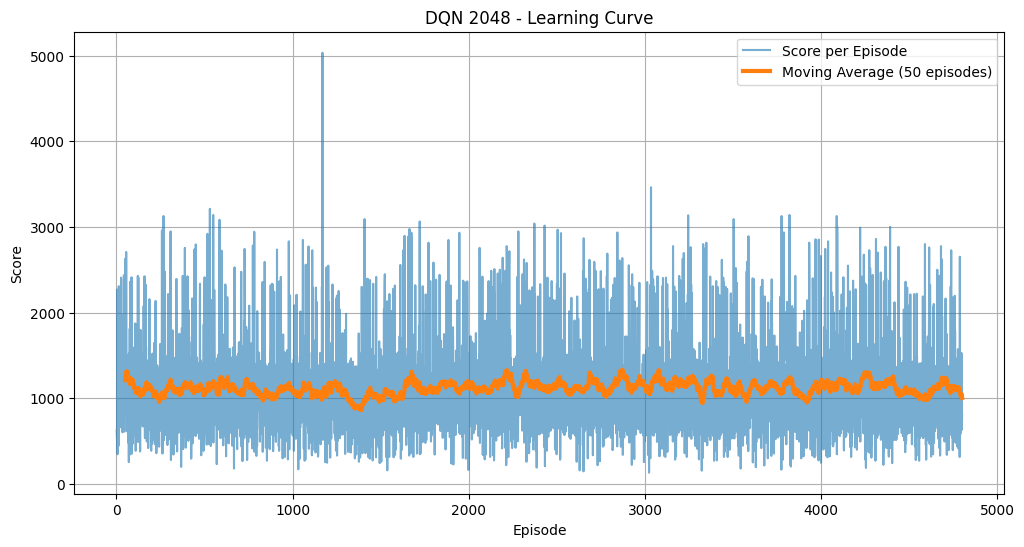

In [2]:

import pandas as pd
import matplotlib.pyplot as plt


SCORES_FILE = "scores_checkpoint.csv"


df = pd.read_csv(SCORES_FILE)

plt.figure(figsize=(12, 6))
plt.plot(df['Episode'], df['Score'], label='Score per Episode', alpha=0.6)
plt.plot(df['Episode'], df['Score'].rolling(window=50).mean(), 
         label='Moving Average (50 episodes)', linewidth=3)

plt.xlabel("Episode")
plt.ylabel("Score")
plt.title("DQN 2048 - Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


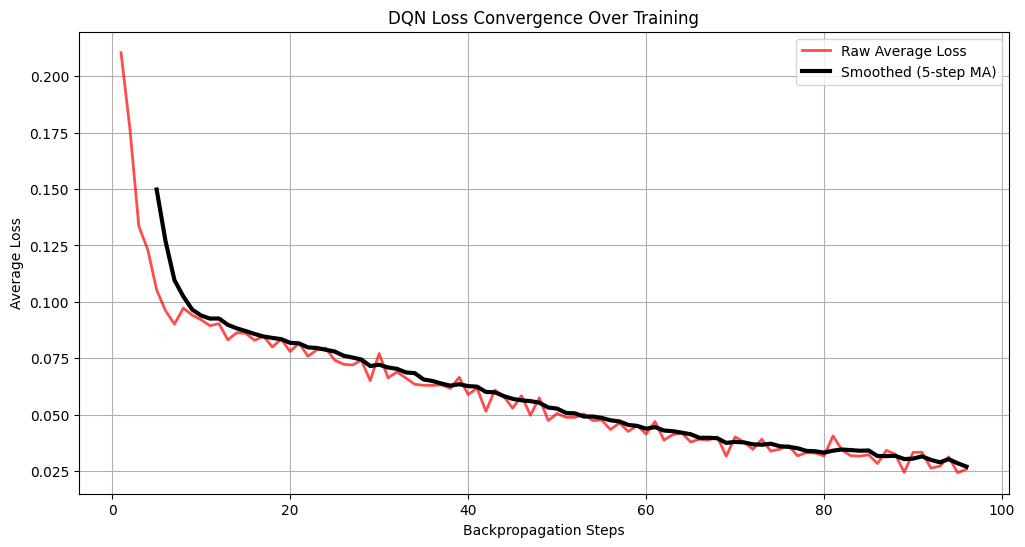

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

LOSS_FILE = "loss_checkpoint.csv"

df_loss = pd.read_csv(LOSS_FILE)


plt.figure(figsize=(12, 6))


plt.plot(
    df_loss["Backprop_Step"],
    df_loss["Average_Loss"],
    color="red",
    alpha=0.7,
    linewidth=2,
    label="Raw Average Loss"
)


window = 5  

plt.plot(
    df_loss["Backprop_Step"],
    df_loss["Average_Loss"].rolling(window).mean(),
    color="black",
    linewidth=3,
    label=f"Smoothed ({window}-step MA)"
)

# ---- Labels & Style ----
plt.title("DQN Loss Convergence Over Training")
plt.xlabel("Backpropagation Steps")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)

plt.show()


